# Labelling stroke units on the maps

This notebook gives examples of how to label the stroke unit names on a map.

> These docs are for plotting with matplotlib.

The two examples on this page are:
+ Writing a text label on the map above each stroke unit marker.
+ Giving each stroke unit a unique marker and printing its full long name in a legend.

## Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.plot

import pandas as pd
import matplotlib.pyplot as plt

## Load the stroke unit data

Postcodes, stroke team names, services etc. are stored in this dataframe:

In [2]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

Coordinates of each stroke unit are stored in here:

In [3]:
gdf_units = stroke_maps.load_data.stroke_unit_coordinates()

Merge the unit names and services into the coordinates:

In [4]:
gdf_units = pd.merge(
    gdf_units, df_units,
    left_index=True, right_index=True, how='right'
)

In [5]:
gdf_units.head(3).T

postcode,SY231ER,CB20QQ,L97AL
BNG_E,259208,546375,338020
BNG_N,281805,254988,397205
Latitude,52.416068,52.173741,53.467918
Longitude,-4.071578,0.139114,-2.935131
geometry,POINT (259208 281805),POINT (546375 254988),POINT (338020 397205)
stroke_team,Bronglais Hospital (Aberystwyth),"Addenbrooke's Hospital, Cambridge","University Hospital Aintree, Liverpool"
short_code,AB,AD,AI
ssnap_name,Bronglais Hospital,Addenbrooke's Hospital,University Hospital Aintree
use_ivt,1,1,1
use_mt,0,1,1


__TEMPORARY - TO DO__ - put the hospital city names back into the stroke unit data.

Approximate the hospital city names by taking the non-numerical part of the LSOA name.

In [6]:
gdf_units['hospital_city'] = [' '.join(c.split(' ')[:-1]) for c in gdf_units['lsoa'].values]

## Non-overlapping text labels

Notes:
+ On a small (in dimensions) figure, this method runs fairly slowly (a few tens of seconds) and takes increasingly long and gives worse results when there are more very long names in the labels. When the figure size is larger, the method runs more quickly. Presumably this is because it has less jiggling around of the labels to attempt.

First load the outline of England and Wales:

In [7]:
gdf_ew = stroke_maps.load_data.englandwales_outline()

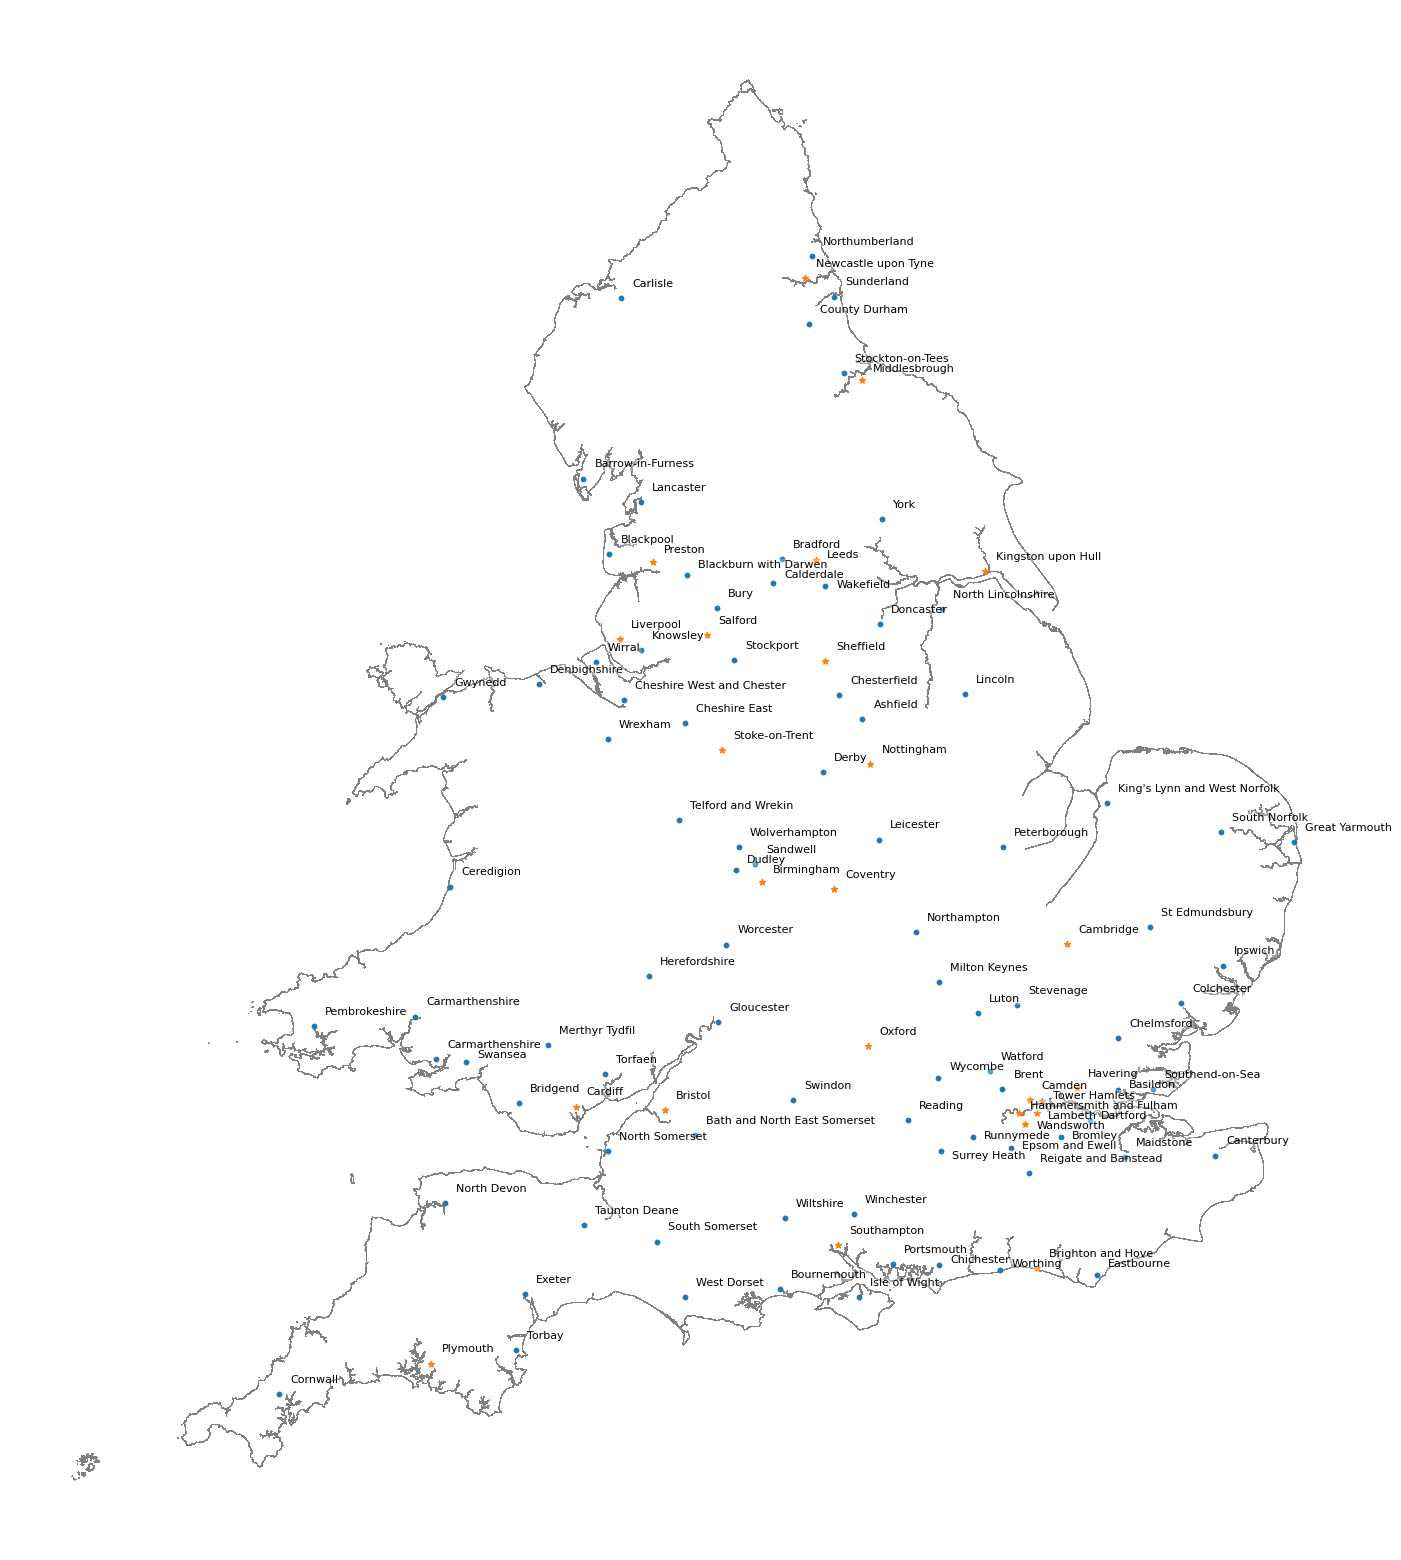

In [8]:
# Make the figsize enormous to give the labels breathing room.
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the country outlines:
gdf_ew.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',
    edgecolor='grey',
    linewidth=0.2,
    )

# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)

# IVT units:
ax.scatter(
    gdf_units.loc[mask_ivt, 'geometry'].x,
    gdf_units.loc[mask_ivt, 'geometry'].y,
    marker='o',
    label='IVT unit',
    s=10,  # size
    )

# MT units:
ax.scatter(
    gdf_units.loc[mask_mt, 'geometry'].x,
    gdf_units.loc[mask_mt, 'geometry'].y,
    marker='*',
    label='MT unit',
    s=20,  # size
    )

ax = stroke_maps.plot.add_nonoverlapping_text_labels(
    gdf_units.loc[mask_ivt | mask_mt], ax, 'hospital_city', y_step=0.05, fontsize=8)

# Remove the axis border, ticks, labels...
ax.axis('off')

plt.show()

## Short codes and a long legend

Stroke units tend to have long names and it's difficult to fit these onto a map, let alone to see anything else that's on the map behind the labels.

Instead mark each stroke unit with its own marker and make a long legend that has the full names.

__TO DO:__ currently the short codes are stored with the usual stroke unit data. Pull them out into their own file.

The legend will contain these contents:

In [9]:
gdf_units[['short_code', 'ssnap_name']].set_index('short_code')

,ssnap_name
short_code,
AB,Bronglais Hospital
AD,Addenbrooke's Hospital
AI,University Hospital Aintree
AR,Wirral Arrowe Park Hospital
BA,Royal United Hospital Bath
...,...
WX,Wexham Park Hospital
WY,Wycombe General Hospital
YE,Yeovil District Hospital


Add a column to the `gdf_units` GeoDataFrame that sets the marker shape for each unit. Set IVT units to a circle and MT units to a star.

In [10]:
# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)
mask = mask_ivt | mask_mt

In [11]:
gdf_units['marker'] = 'o'  # circle
gdf_units.loc[mask_mt, 'marker'] = '*'  # star

The plot:

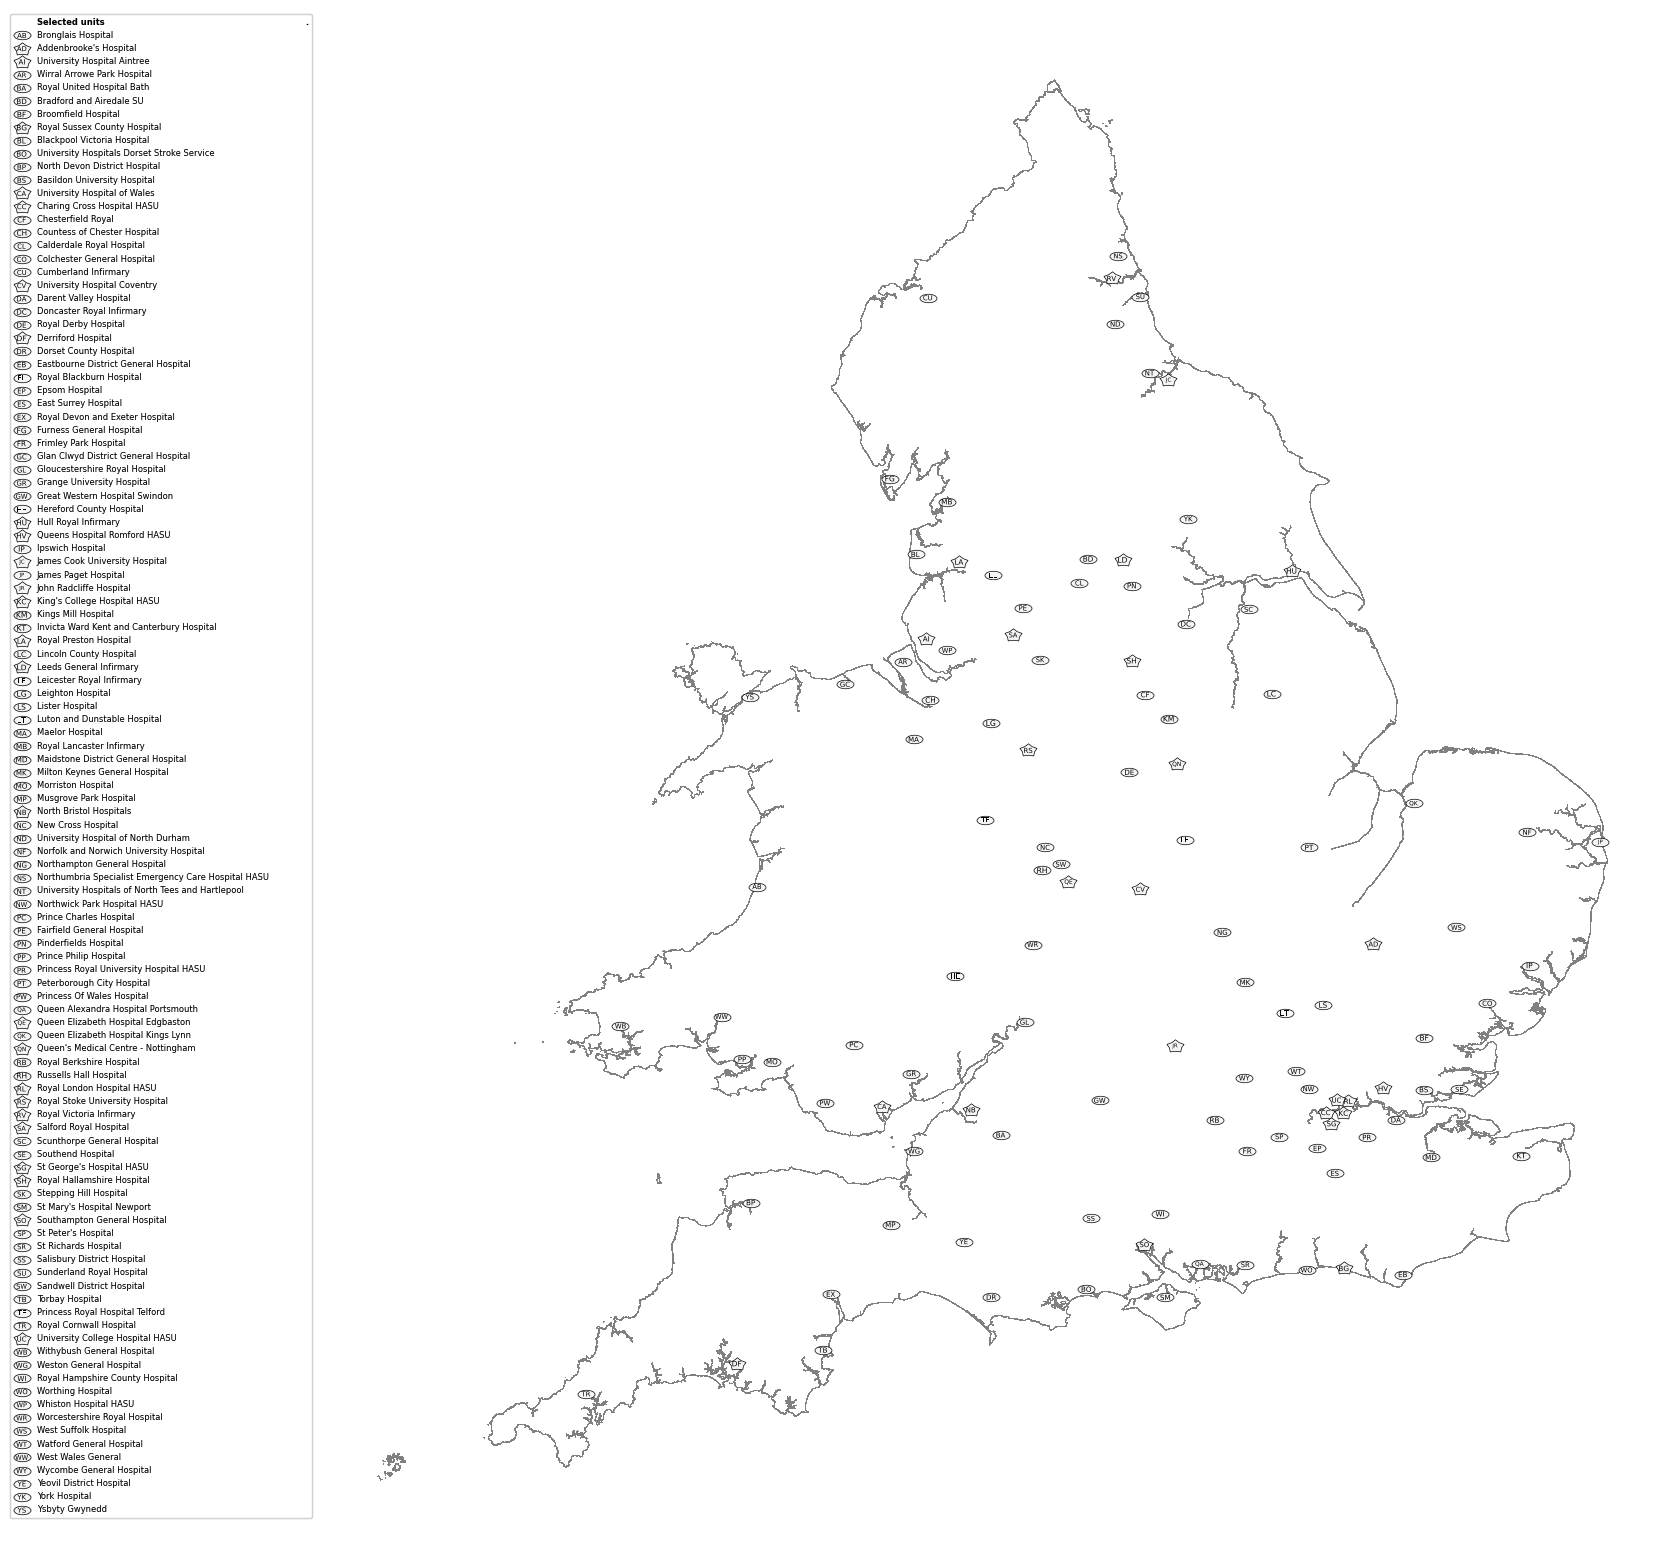

In [12]:
# Make the figsize enormous to give the labels breathing room.
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the country outlines:
gdf_ew.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',
    edgecolor='grey',
    linewidth=0.2,
    )

ax, handles_scatter_us = stroke_maps.plot.scatter_units(
    ax,
    gdf_units[mask],
    return_handle=True,
    # The following kwargs are passed to plt.scatter():
    facecolor='WhiteSmoke',
    edgecolor='k',
    )

ax, handles_us, labels_us = stroke_maps.plot.draw_labels_short(
    ax,
    gdf_units.loc[mask, 'geometry'],    # coordinates
    gdf_units.loc[mask, 'short_code'],  # text for each marker
    gdf_units.loc[mask, 'ssnap_name'],  # long name for the legend
    # The following kwargs are passed to plt.scatter():
    s=10,  # label size
    color='k',
    # bbox=dict(facecolor='WhiteSmoke', edgecolor='r'),
)

section_labels = ['Selected units' + ' ' * 70 + '.']
handles_lists = [
    [handles_scatter_us, handles_us]
]
labels_lists = [labels_us]

leg2 = stroke_maps.plot.create_units_legend(
    ax,
    handles_lists,
    labels_lists,
    section_labels,
    # The following kwargs are passed to plt.legend():
    fontsize=6,
    bbox_to_anchor=[0.0, 1.0],
    loc='upper right'
    )


# Remove the axis border, ticks, labels...
ax.axis('off')

# Add the legend as an "extra artist" so that bbox_inches='tight' line
# in savefig() doesn't cut off the legends.
# Adding legends with ax.add_artist() means that the
# bbox_inches='tight' line ignores them.
extra_artists = (leg2, )

save_fig = False
if save_fig:
    # Include extra artists so that bbox_inches='tight' line
    # in savefig() doesn't cut off the legends.
    # Adding legends with ax.add_artist() means that the
    # bbox_inches='tight' line ignores them.
    plt.savefig(
        'output/map.png',
        bbox_extra_artists=extra_artists,
        dpi=300, bbox_inches='tight'
        )

# Add dummy axis to the sides so that
# extra_artists are not cut off when plt.show() crops.
fig = stroke_maps.plot.plot_dummy_axis(fig, ax, extra_artists[0], side='left')
plt.show()
